In [1]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from glob import glob
from PIL import Image
import seaborn as sns
import math
import random
import xarray as xr
from torch.masked import masked_tensor, as_masked_tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time

In [2]:
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
#train_path_list

In [4]:
train_path_list[0]

'/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/train/ASO_50M_SD_RoaringFork_20230528_clean_tile80_s15.nc'

In [5]:
ds = xr.open_dataset(train_path_list[0])
ds

<xarray.Dataset>
Dimensions:           (y: 128, x: 128)
Coordinates:
    band              int64 ...
  * x                 (x) float64 3.447e+05 3.447e+05 ... 3.51e+05 3.51e+05
  * y                 (y) float64 4.333e+06 4.333e+06 ... 4.327e+06 4.326e+06
    time              datetime64[ns] ...
    spatial_ref       int64 ...
Data variables: (12/30)
    aso_sd            (y, x) float32 ...
    snowon_vh         (y, x) float32 ...
    snowon_vv         (y, x) float32 ...
    snowoff_vh        (y, x) float32 ...
    snowoff_vv        (y, x) float32 ...
    snowon_vh_mean    (y, x) float32 ...
    ...                ...
    visual            (y, x) float32 ...
    fcf               (y, x) float64 ...
    elevation         (y, x) float32 ...
    aso_gap_map       (y, x) int64 ...
    rtc_gap_map       (y, x) int64 ...
    rtc_mean_gap_map  (y, x) int64 ...

In [6]:
ds.time

<xarray.DataArray 'time' ()>
[1 values with dtype=datetime64[ns]]
Coordinates:
    band         int64 ...
    time         datetime64[ns] ...
    spatial_ref  int64 ...

In [7]:
ds.time.values

numpy.datetime64('2023-05-19T13:10:07.909768000')

(array([1.6199e+04, 1.5700e+02, 1.1000e+01, 6.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([ 0.        ,  1.46219826,  2.92439651,  4.38659477,  5.84879303,
         7.31099129,  8.77318954, 10.2353878 , 11.69758606, 13.15978432,
        14.62198257]),
 <BarContainer object of 10 artists>)

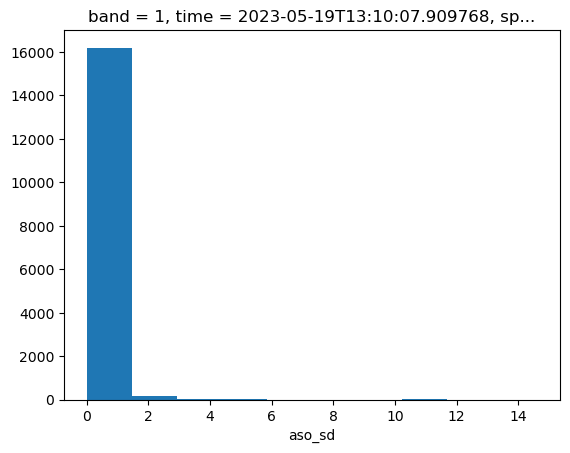

In [8]:
ds.aso_sd.plot.hist()

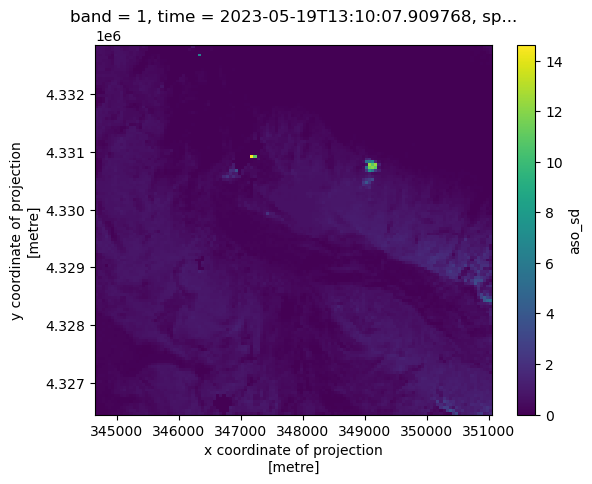

In [9]:
ds.aso_sd.plot()

In [10]:
def calc_norm(tensor, minmax_list):
    '''
    normalize a tensor between 0 and 1 using a min and max value stored in a list
    '''
    normalized = (tensor-minmax_list[0])/(minmax_list[1]-minmax_list[0])
    return normalized

In [11]:
len(train_path_list)

25051

### (Re-)Create norm_dict from training dataset
#### (aka, an exercise to get acquainted with xarray!)

In [12]:
n = 500 # subset size to test performance

In [13]:
# A first attempt #
def range1(indata):
    for i, d in enumerate(indata): # Test (time) performance on subset of training data
        ds = xr.open_dataset(d)
        if i == 0:
            var_list = list(ds.data_vars)
            range_dict = dict({k: [np.inf, -np.inf] for k in var_list})
        for var in var_list:
            cur_max = ds[var].values.max()
            cur_min = ds[var].values.min()
            if cur_max>range_dict[var][1]: range_dict[var][1] = cur_max
            if cur_min<range_dict[var][0]: range_dict[var][0] = cur_min
    return range_dict

%time range_dict1 = range1(train_path_list[:n])
#range_dict1

CPU times: user 12.4 s, sys: 1.5 s, total: 13.9 s
Wall time: 38.9 s


In [14]:
# Second attempt
# Try to improve performance by using inherent structure of xarray and
# find mins, maxs outside loop to reduce computation

def range2(indata):
    cur_mins = []
    cur_maxs = []
    for d in indata: # Test (time) performance on subset of training data
        ds = xr.open_dataset(d)
        cur_mins.append(ds.min())
        cur_maxs.append(ds.max())
    mins = xr.concat(cur_mins, dim = 'min').min()
    maxs = xr.concat(cur_maxs, dim = 'max').max()
    range_dict = {k: [float(mins[k].min()), float(maxs[k].max())] for k in list(mins.data_vars)}
    return(range_dict)
    
%time range_dict2 = range2(train_path_list[:n])
#range_dict2

CPU times: user 43 s, sys: 6 s, total: 49 s
Wall time: 2min 38s


In [15]:
# Try again....
# This time, loop over variables (as in first run), but store all extreme values in one list and 
# pull computatation out of loop

def range3(indata):
    for i, d in enumerate(indata): # Test (time) performance on subset of training data
        ds = xr.open_dataset(d)
        if i == 0:
            var_list = list(ds.data_vars)
            extremes_dict = dict({k: [] for k in var_list})
        for var in var_list:
            extremes_dict[var].extend([ds[var].values.max(), ds[var].values.min()])
    range_dict = {k: [min(v), max(v)] for k, v in extremes_dict.items()} 
    return range_dict
    
%time range_dict3 = range3(train_path_list[:n])
#range_dict3

CPU times: user 14.9 s, sys: 1.66 s, total: 16.5 s
Wall time: 33.5 s


In [17]:
%time range_dict = range3(train_path_list)

range_dict

CPU times: user 12min 10s, sys: 1min 22s, total: 13min 32s
Wall time: 56min 32s


{'aso_sd': [0.0, 24.83628],
 'snowon_vh': [0.0, 35.78091],
 'snowon_vv': [0.0, 8774.097],
 'snowoff_vh': [0.0, 36.05591],
 'snowoff_vv': [0.0, 13523.74],
 'snowon_vh_mean': [0.0, 43.186153],
 'snowon_vv_mean': [0.0, 4794.3115],
 'snowoff_vh_mean': [0.0, 30.40638],
 'snowoff_vv_mean': [0.0, 10761.114],
 'AOT': [0.0, 572.0],
 'B01': [0.0, 23459.0],
 'B02': [0.0, 23004.0],
 'B03': [0.0, 26440.0],
 'B04': [0.0, 21576.0],
 'B05': [0.0, 20796.0],
 'B06': [0.0, 20432.0],
 'B07': [0.0, 20149.0],
 'B08': [0.0, 21217.0],
 'B09': [0.0, 18199.0],
 'B11': [0.0, 17549.0],
 'B12': [0.0, 17314.0],
 'B8A': [0.0, 20981.0],
 'SCL': [0.0, 15.0],
 'WVP': [0.0, 6517.438],
 'visual': [0.0, 255.0],
 'fcf': [0.0, 1.0],
 'elevation': [0.0, 4408.2915],
 'aso_gap_map': [0, 1],
 'rtc_gap_map': [0, 1],
 'rtc_mean_gap_map': [0, 1]}

In [4]:
# these are set by finding the min and max across the entire dataset
norm_dict = {'aso_sd':[0, 24.9],
             'vv':[0, 13523.8],
             'vh':[0, 43.2],
             'AOT':[0, 572.1],
             'coastal':[0, 23459.1],
             'blue':[0, 23004.1],
             'green':[0, 26440.1],
             'red':[0, 21576.1],
             'red_edge1':[0, 20796.1],
             'red_edge2':[0, 20432.1],
             'red_edge3':[0, 20149.1],
             'nir':[0, 21217.1],
             'water_vapor':[0, 18199.1],
             'swir1':[0, 17549.1],
             'swir2':[0, 17314.1],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6517.5],
             'elevation':[-100, 9000]}